# ***`Cascade Prediction`***
---

#### 1. **Dataset Preparation**: 
   - **Create two datasets**: 

      - Dataset 1 (LIWC + Big5 traits) 

      - Dataset 2 (LIWC + consumption behaviors).

  - **Feature Selection**: 

    - Select features based on correlation coefficient > 0.5 and p-value < 0.1.

   - **Feature Distribution Analysis**:
     - Conduct statistical tests like Kolmogorov-Smirnov or Anderson-Darling test to ensure LIWC feature distributions 
     in both datasets come from the same distribution. If not, utilize a unified dataset (Big5 + LIWC + Consumption).

         - `Not neccessary since dataset 2 is subset if dataset 1 in terms of observations`

#### 2. **Model Training for Big5 Traits (First Layer)**: 
   - Train models on LIWC features to predict Big5 traits, employing cross-validation and hyperparameter tuning. Ensure the models do not overfitt!
      - `Ensure that observations from dataset 2 are not present in model training at layer 1!?`

#### 3. **Generating Predicted Big5 Traits**: 
   - Use the trained & carefully evaluated models to predict Big5 traits from LIWC features in Dataset 2.

#### 4. **Enrich Dataset 2**: 
   - Incorporate the predicted Big5 traits into Dataset 2, resulting in a new dataset with LIWC features and predicted Big5 traits.

#### 5. **Final Prediction (Second Layer)**: 
   - Train models on the enriched Dataset 2 to predict consumption behaviors, utilizing only the predicted Big5 traits as input features.

#### 6. **Evaluation and Analysis**: 
   - Evaluate the performance of the final models, ensuring no significant overfitting and reasonable predictive accuracy.


#### `-> This approach highlights using only predicted Big5 traits for predicting consumption behaviors, adhering to the cascading prediction framework.`
---

In [2]:
rewe = 31.5

silvester = 161.5 - 50

alc = 68

döner = 22

cola = 50

eintritt = 10

basti = (rewe /2) + (silvester /3) + (alc /2) + (döner /2) + (cola ) + eintritt

pfisiti = (rewe /2) + (silvester /3) + (alc /2) + (döner /2)


print("Basti: " + str(basti) + " €")
print("Pfisiti: " + str(pfisiti) + " €")

Basti: 157.91666666666666 €
Pfisiti: 97.91666666666666 €


In [4]:
# jeder gezahlt wenn man nur uns beide betrachtet
basti = rewe + (silvester*(2/3))
pfisti = döner + alc

print(f"Basti: {basti} €")
print(f"Pfisiti: {pfisti} €")

Basti: 105.83333333333333 €
Pfisiti: 90 €


In [5]:
# basti plus was er pfisit sowieso schuldet
basti = basti -5 + eintritt + cola - pfisti
basti

70.83333333333331

## ***Import Libraries:***

In [1]:
import pandas as pd

# enable to see all columns:
pd.set_option('display.max_columns', None)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

from typing import List, Any
from sklearn.base import BaseEstimator
from sklearn.metrics import precision_score, recall_score, f1_score

# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## ***Import Helper Functions:***

In [2]:
from helper_functions import *

## ***1) Data Set Preparation***
---

In [3]:
from sklearn.model_selection import train_test_split

### **1.1) Read Data:**

#### 1.1.1) df1 = liwc + big5

In [4]:
df1 = pd.read_parquet('merged_data/df_cascade_big5_liwc.parquet')
print(f"Duplicates: {df1.duplicated().sum()}")
print(f"Missing values: {df1.isnull().sum().sum()}")
print()
display_data_shape(df1)
df1.head()

Duplicates: 0
Missing values: 0

Data dimensions:
---------------------------------------------------------------------
 - Number of observations: 115,822
 - Number of columns: 100


,userid,ope,con,ext,agr,neu,blocks,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function.,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,54de19c35a7e3f964d782bde726439dc,4.25,1.95,4.15,4.20,3.25,336,731,62.59,48.36,72.70,59.45,15.23,16.28,83.58,48.43,12.59,8.21,4.79,0.55,2.19,0.27,0.41,4.38,5.47,12.59,6.98,5.20,6.98,2.33,15.32,3.01,1.50,2.05,2.05,2.60,7.25,4.51,2.74,0.27,0.27,0.41,9.30,0.55,1.09,0.14,0.41,11.76,1.50,1.23,2.05,3.28,1.50,5.20,3.15,1.50,0.96,0.55,1.50,0.41,0.41,0.00,0.68,8.62,3.01,1.50,3.01,1.37,0.41,1.64,12.72,2.19,15.46,2.74,7.25,5.47,2.33,1.92,1.23,0.41,0.14,0.00,2.74,0.14,2.05,0.27,0.41,0.00,22.16,4.51,4.51,1.50,0.00,1.09,2.19,1.23,0.82,2.60,1.78,1.92
1,7267f43c71fcf53f4580fd3cd808bd48,4.00,2.25,2.20,3.60,2.80,336,97,92.84,69.70,22.64,25.77,10.78,22.68,73.20,41.24,9.28,3.09,2.06,0.00,1.03,0.00,0.00,6.19,8.25,12.37,7.22,1.03,3.09,0.00,15.46,4.12,1.03,2.06,1.03,0.00,8.25,4.12,4.12,0.00,4.12,0.00,8.25,0.00,0.00,0.00,1.03,12.37,4.12,1.03,3.09,5.15,0.00,1.03,5.15,4.12,0.00,1.03,1.03,0.00,0.00,0.00,0.00,5.15,1.03,3.09,3.09,1.03,0.00,1.03,11.34,1.03,12.37,3.09,7.22,2.06,4.12,0.00,0.00,1.03,1.03,1.03,1.03,1.03,0.00,0.00,0.00,0.00,25.77,9.28,4.12,2.06,0.00,1.03,5.15,1.03,2.06,0.00,0.00,1.03
2,e42578889c836a5fc0480c7696ac11a9,3.85,2.95,2.80,3.75,3.20,336,64,87.07,43.79,92.60,99.00,21.33,9.38,71.88,46.88,12.50,9.38,6.25,0.00,1.56,0.00,1.56,3.12,9.38,12.50,6.25,4.69,3.12,0.00,14.06,1.56,0.00,0.00,10.94,1.56,7.81,7.81,0.00,0.00,0.00,0.00,3.12,0.00,0.00,0.00,0.00,6.25,1.56,0.00,1.56,1.56,1.56,0.00,1.56,1.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.25,0.00,1.56,0.00,6.25,0.00,4.69,9.38,1.56,23.44,0.00,10.94,15.62,1.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,25.00,0.00,12.50,1.56,0.00,1.56,3.12,0.00,0.00,0.00,0.00,6.25
3,e1cdac10d136e76e064e4860007d786d,4.20,3.35,2.45,3.90,2.60,336,24,80.75,10.58,48.89,25.77,6.00,16.67,79.17,37.50,16.67,8.33,8.33,0.00,0.00,0.00,0.00,8.33,4.17,12.50,0.00,8.33,0.00,0.00,16.67,4.17,0.00,0.00,8.33,4.17,8.33,4.17,4.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16.67,4.17,0.00,4.17,4.17,4.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.33,4.17,12.50,0.00,0.00,12.50,0.00,0.00,0.00,0.00,0.00,0.00,4.17,4.17,0.00,0.00,0.00,0.00,20.83,8.33,4.17,0.00,0.00,4.17,4.17,0.00,0.00,0.00,0.00,0.00
4,b9a44bb356832160caccc9eb3614e0ce,4.50,2.35,3.65,3.45,3.15,336,4601,61.63,47.91,52.14,43.17,8.14,14.67,84.72,48.71,11.93,7.41,4.04,0.52,0.93,1.80,0.11,4.50,5.61,12.39,9.06,6.35,5.39,1.63,18.10,4.39,1.52,0.89,1.61,1.70,7.54,4.22,3.26,0.22,1.24,0.78,7.76,0.33,0.20,2.09,0.24,11.26,1.78,1.02,2.26,3.13,1.41,3.24,2.67,0.98,0.76,0.70,3.39,1.26,0.89,0.17,0.87,6.59,1.98,1.28,1.56,1.89,0.46,2.93,13.91,2.09,16.32,2.35,6.98,7.48,1.67,1.93,0.93,0.72,0.22,0.15,3.17,0.83,1.54,0.37,0.41,0.09,40.47,15.39,3.98,1.26,0.28,1.13,5.24,1.72,0.91,3.46,1.43,5.67


#### 1.1.2) df2 = liwc + consumption

In [5]:
df2 = pd.read_parquet('merged_data/df_cascade_consumption_liwc.parquet')
print(f"Duplicates: {df2.duplicated().sum()}")
print(f"Missing values: {df2.isnull().sum().sum()}")
print()
display_data_shape(df2)
df2.head()

Duplicates: 0
Missing values: 0

Data dimensions:
---------------------------------------------------------------------
 - Number of observations: 1,185
 - Number of columns: 97


,userid,smoking_status,alcohol_status,drug_status,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function.,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,ba4d96426226699b8c511ce0bee75941,True,True,True,7197,43.31,59.44,60.57,44.88,19.94,11.39,82.03,45.07,15.92,11.45,6.27,0.42,3.49,0.51,0.76,4.47,4.15,9.11,7.95,4.71,5.46,2.08,17.13,4.59,1.70,1.56,2.15,1.76,7.54,4.28,3.24,0.24,1.29,0.58,11.17,1.36,0.53,1.29,0.83,10.56,2.32,1.13,1.90,2.24,1.35,3.36,3.06,1.14,0.60,1.08,3.97,1.28,1.18,0.50,0.71,7.25,2.47,0.82,2.18,1.93,0.43,2.90,12.95,1.74,13.07,2.14,5.66,5.29,0.76,1.46,0.79,0.76,0.40,0.21,7.35,0.97,5.54,0.25,0.42,0.04,31.15,2.96,1.65,0.79,0.07,2.88,17.02,0.40,0.69,2.50,0.49,1.70
1,1a388284961e77942bae7a0ead109eea,False,True,False,4025,35.20,73.85,50.29,70.64,8.67,10.71,81.66,46.26,18.76,14.16,7.08,0.77,5.47,0.40,0.45,4.60,4.05,8.99,8.52,4.57,5.44,1.57,17.89,5.19,1.79,1.49,4.89,1.27,9.69,5.96,3.58,0.37,1.57,0.50,12.50,0.42,0.75,0.65,0.72,10.01,1.91,1.61,2.09,2.19,1.69,2.11,3.38,1.49,0.92,0.62,4.47,1.86,0.70,0.55,0.87,7.18,2.78,0.75,2.01,1.96,0.37,2.53,12.45,2.21,12.42,1.91,5.84,4.89,0.77,1.59,0.17,0.22,0.30,0.47,4.37,1.59,2.36,0.25,0.25,0.00,38.63,13.59,5.86,2.46,0.32,1.74,1.74,1.09,1.81,4.45,1.59,3.98
2,ec539b2398f80d1f395ba4cc06c230a7,False,False,False,2741,51.55,71.78,53.26,90.03,13.77,14.19,86.25,51.77,14.52,10.69,4.85,1.31,2.59,1.61,0.33,3.83,5.25,12.29,10.40,5.18,5.87,1.53,19.41,4.38,0.95,1.64,1.35,1.50,7.88,5.87,2.01,0.04,0.36,0.84,10.65,0.47,0.40,1.39,0.80,8.79,1.64,0.73,1.64,2.19,1.64,2.26,2.48,1.28,0.40,0.66,2.59,0.58,0.95,0.00,0.51,7.66,3.06,0.91,1.68,1.97,0.29,5.18,12.81,3.47,15.98,2.59,6.09,7.59,1.42,1.79,1.39,0.26,1.17,0.11,2.23,0.15,1.06,0.36,0.51,0.00,20.32,7.00,4.52,0.95,0.11,0.33,3.83,0.47,0.44,2.19,0.26,0.22
3,0e0b122ce777606ae73dd055d76fc1c7,False,False,False,5,8.19,50.00,1.00,1.00,1.67,20.00,80.00,40.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,20.00,0.00,20.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,0.00,0.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,40.00,0.00,0.00,0.00,20.00,60.00,0.00,0.00,0.00,0.00,0.00
4,58bcb86a962fc98d2feb5e3562ac45c0,True,True,False,1548,48.77,42.07,79.91,77.98,8.70,12.21,86.95,48.45,15.44,10.01,7.69,0.65,1.03,0.32,0.32,5.43,5.56,10.53,9.63,5.81,4.65,1.49,18.22,5.17,1.61,1.36,3.68,2.00,6.91,4.84,2.00,0.19,0.45,0.26,7.69,0.90,0.26,0.32,0.84,9.04,1.42,0.97,2.20,2.13,1.36,2.07,2.78,1.10,0.71,0.58,3.49,0.90,0.97,0.00,1.49,6.65,2.26,1.61,1.68,1.87,0.26,3.49,13.44,2.91,17.38,3.04,5.17,9.69,2.26,3.04,0.26,0.58,0.45,0.06,2.97,0.13,1.74,0.71,0.52,0.06,45.09,18.54,1.68,0.19,0.06,1.61,12.14,1.49,1.16,4.13,1.49,2.58


##### ***`Note`:*** Dataset 2 is a subset of dataset 1 except for 100 observations!
##### Drop observations of df1 that are in df2:

In [41]:
df1 = df1[~df1['userid'].isin(df2['userid'])]
display_data_shape(df1)

Data dimensions:
---------------------------------------------------------------------
 - Number of observations: 114,740
 - Number of columns: 100


##### `Filter based on word count (WC)?`

Minimum word count: 1


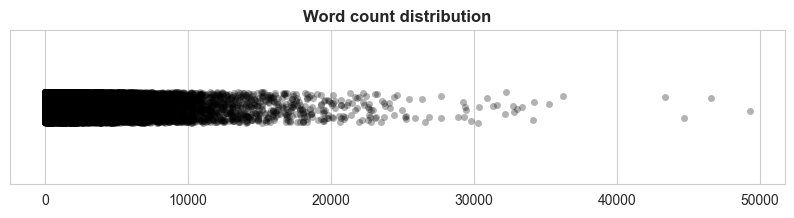

In [42]:
plt.figure(figsize=(10, 2))
plt.title('Word count distribution', weight='bold')
sns.stripplot(
        x='WC', data=df1.query('blocks >= 100'),
        jitter=True, alpha=.3,
        color='black'
)
plt.xlabel("")
print(f"Minimum word count: {df1['WC'].min()}")


In [44]:
threshold = int(input("Enter the minimum word count: ")) # 50
df1 = df1.query('WC >= @threshold')
display_data_shape(df1)

Data dimensions:
---------------------------------------------------------------------
 - Number of observations: 109,407
 - Number of columns: 100


##### `Filter based on questions answered (blocks)?`
- Observations having answered more questions based on a higher threshold have more accurate trait metrics.

Number of individuals having answered at least 100 questions: 24709


blocks
20     70745
100    24165
30      4477
50      2947
40      2662
60      1534
70      1001
80       741
90       591
336      544
Name: count, dtype: int64

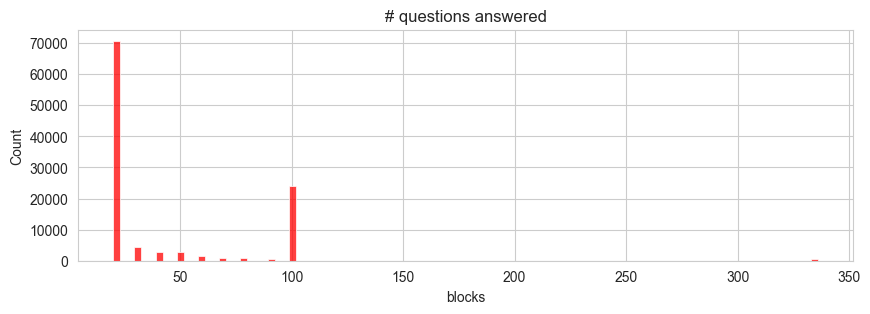

In [45]:
plt.figure(figsize=(10, 3))
sns.histplot(x='blocks', data=df1, bins=100, color='red')
plt.title('# questions answered');
print(f"Number of individuals having answered at least 100 questions: {df1[df1['blocks'] >= 100].shape[0]}")
df1.blocks.value_counts()

- ***`Blocks Analysis with respect to traits:`***

   - Analyze the variability (standard deviation) of Big5 scores at different block lengths. Reduced variability at higher block lengths might indicate more consistent and reliable responses.

   -  Create line plots or bar charts to visualize how the average scores of each Big5 trait change with different block lengths. Look for patterns or points where scores begin to stabilize.

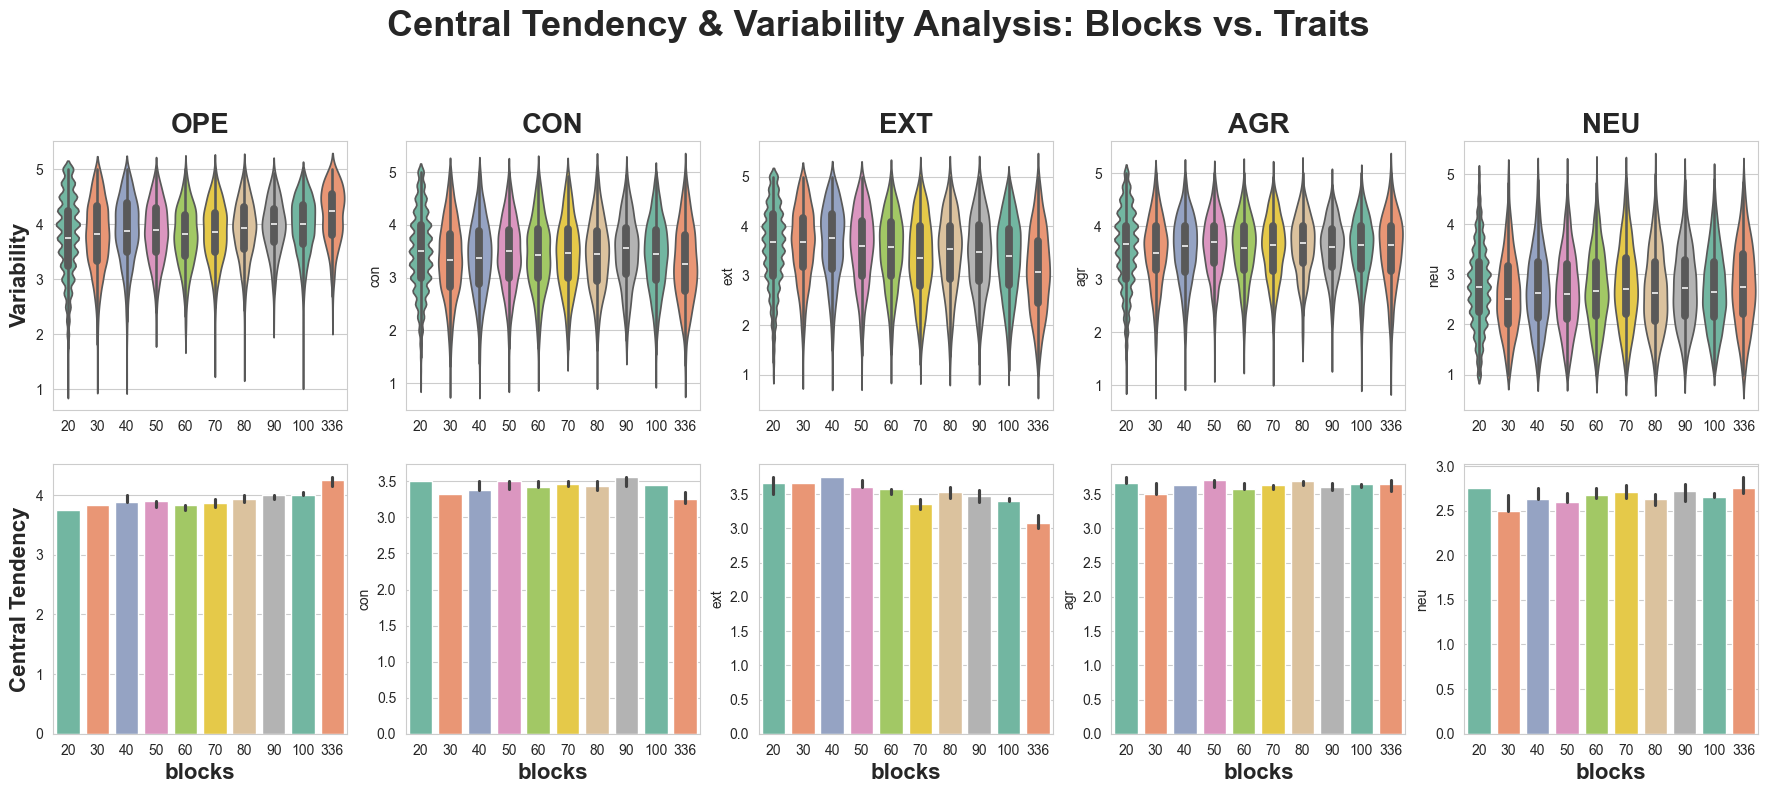

In [46]:
# violin plot median/mean plot for each block (hue=trait)
blocks = sorted(df1.blocks.unique().tolist())
ocean  = ['ope', 'con', 'ext', 'agr', 'neu']

fig, ax = plt.subplots(nrows=2, ncols=len(ocean), figsize=(22, 7.7))
fig.suptitle('Central Tendency & Variability Analysis: Blocks vs. Traits', fontsize=26, weight='bold', y=1.05)

#violin plots in the first row & bar (mean) plots in the second row
for n, trait in enumerate(ocean):
    sns.violinplot(x='blocks', y=trait, data=df1, ax=ax[0][n], palette='Set2')
    ax[0][n].set_title(trait.upper(), fontsize=20, weight='bold')
    ax[0][n].set_xlabel('')
    ax[0][0].set_ylabel('Variability', fontsize=16, weight='bold')

    sns.barplot(x='blocks', y=trait, data=df1, ax=ax[1][n], palette='Set2', estimator=np.median)
    ax[1][n].set_xlabel('blocks', fontsize=16, weight='bold')
    ax[1][0].set_ylabel('Central Tendency', fontsize=16, weight='bold')

---> It is noticed that when setting the threshold up to 80 the distribution of the traits is smoother with less disturbing peaks.


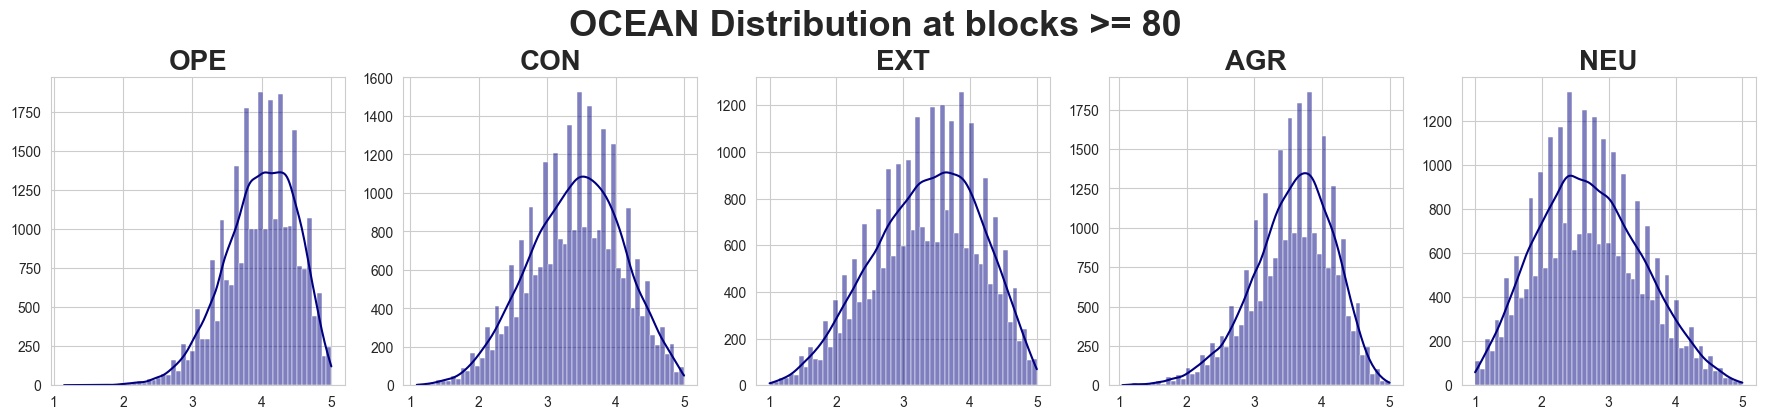

In [14]:
threshold = int(input("Please enter a threshold: "))

fig, ax = plt.subplots(nrows=1, ncols=len(ocean), figsize=(22, 4))
fig.suptitle(f'OCEAN Distribution at blocks >= {threshold}', fontsize=26, weight='bold', y=1.05)

for n, trait in enumerate(ocean):
    sns.histplot(
            x=trait,  data=df1.query("blocks >= @threshold"),
            ax=ax[n], bins=55,
            color='navy', kde=True
    )
    ax[n].set_title(trait.upper(), fontsize=20, weight='bold')
    ax[n].set_xlabel('')
    ax[n].set_ylabel('')

print(f"---> It is noticed that when setting the threshold up to 80 the distribution of the traits is smoother with less disturbing peaks.")

- Set threshold:

In [47]:
threshold = int(input("Enter the minimum number of questions answered: ")) # 80
print(f"Threshold: {threshold}\n")
df1 = df1[df1['blocks'] >= threshold]
display_data_shape(df1)

Threshold: 80

Data dimensions:
---------------------------------------------------------------------
 - Number of observations: 26,041
 - Number of columns: 100


##### Train-Test-Split

- define feature & predictor variables:

In [48]:
liwc = df1.columns[7:]
ocean =['ope', 'con', 'ext', 'agr', 'neu']

ocean_liwc = ocean + liwc.tolist()

- Split:

In [49]:
X1, y1 = df1[liwc], df1[ocean]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

### **1.2) Feature Selection:**

In [50]:
# define train set for feature selection (features and targets)
train_df = pd.concat([X_train1, y_train1], axis=1)
train_df.columns

Index(['WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'Sixltr', 'Dic',
       'function.', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they',
       'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate',
       'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'affect',
       'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend',
       'female', 'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat',
       'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body',
       'health', 'sexual', 'ingest', 'drives', 'affiliation', 'achieve',
       'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture',
       'relativ', 'motion', 'space', 'time', 'work', 'leisure', 'home',
       'money', 'relig', 'death', 'informal', 'swear', 'netspeak', 'assent',
       'nonflu', 'filler', 'AllPunc', 'Period', 'Comma', 'Colon', 'SemiC',
       'QMark', 'Exclam', 'Dash', 'Quote', 'Apostro', 'Parenth', 'OtherP',
       'ope', 

#### Correlation Matrix of LIWC vs Big5:

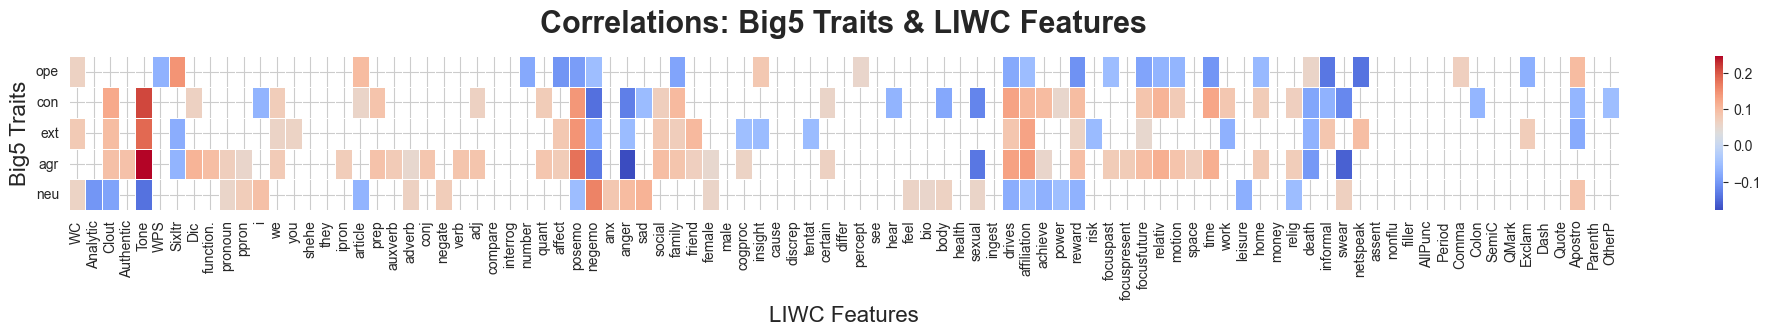

In [51]:
from scipy import stats

# Extracting relevant columns
data = train_df[ocean_liwc]

# Compute the correlation matrix
corr_matrix = data.corr()

# Isolating the correlations between Big5 traits and LIWC features
corr_subset = corr_matrix.loc[ocean, liwc]

#define threshold
threshold = 0.05

# mask
corr_mask = corr_subset.abs() <= threshold

# Creating the heatmap
plt.figure(figsize=(25, 2))
sns.heatmap(corr_subset, annot=False, cmap='coolwarm', linewidths=0.5, mask=corr_mask)
plt.title('Correlations: Big5 Traits & LIWC Features', fontsize=22, weight='bold', y=1.1)
plt.xlabel('LIWC Features', fontsize=16)
plt.xticks(rotation=90)
plt.ylabel('Big5 Traits', fontsize=16)
plt.yticks(rotation=0);

- Features having a correlation higher than 0.05:

In [52]:
# store selected features in lists
ope_corr_selected = corr_subset.loc['ope', corr_subset.loc['ope'].abs() >= threshold].index.tolist()
con_corr_selected = corr_subset.loc['con', corr_subset.loc['con'].abs() >= threshold].index.tolist()
ext_corr_selected = corr_subset.loc['ext', corr_subset.loc['ext'].abs() >= threshold].index.tolist()
agr_corr_selected = corr_subset.loc['agr', corr_subset.loc['agr'].abs() >= threshold].index.tolist()
neu_corr_selected = corr_subset.loc['neu', corr_subset.loc['neu'].abs() >= threshold].index.tolist()

# display selected features
for trait in ocean:
    print(f"Trait: {trait}")
    print(7*'~')
    print(corr_subset.loc[trait, corr_subset.loc[trait].abs() >= 0.05].sort_values(ascending=False))
    print(30*'=')

Trait: ope
~~~~~~~
Sixltr         0.145405
article        0.098237
Apostro        0.098007
insight        0.079910
Comma          0.066856
WC             0.062121
death          0.056812
percept        0.054285
negemo        -0.052618
affiliation   -0.053522
focuspast     -0.054428
home          -0.059423
motion        -0.066050
relativ       -0.067615
WPS           -0.069176
Exclam        -0.072742
number        -0.079683
drives        -0.080639
focusfuture   -0.086999
family        -0.087825
posemo        -0.094936
time          -0.102945
affect        -0.105208
reward        -0.108420
informal      -0.136871
netspeak      -0.140722
Name: ope, dtype: float64
Trait: con
~~~~~~~
Tone           0.211601
posemo         0.141992
drives         0.128784
time           0.125136
Clout          0.121566
relativ        0.107715
affiliation    0.104587
family         0.100059
achieve        0.097677
reward         0.096203
prep           0.086300
focusfuture    0.084420
work           0.081964


#### P-value matrix of OCEAN vs LIWC:
   - The `Bonferroni correction` was applied to address the multiple comparison issue arising from correlating 92 LIWC features with each of the 5 Big Five personality traits.

      - Formula: α* = α / n

      - Where:
        - α* is the adjusted (local) significance level for each trait.
        - α is the global significance level (typically 0.05).
        - n is the number of personality traits (5).
####

   > This method controls the Type-I error rate within each personality trait, ensuring statistical rigor in identifying significant correlations.

   > Aka. alpha accumulation.

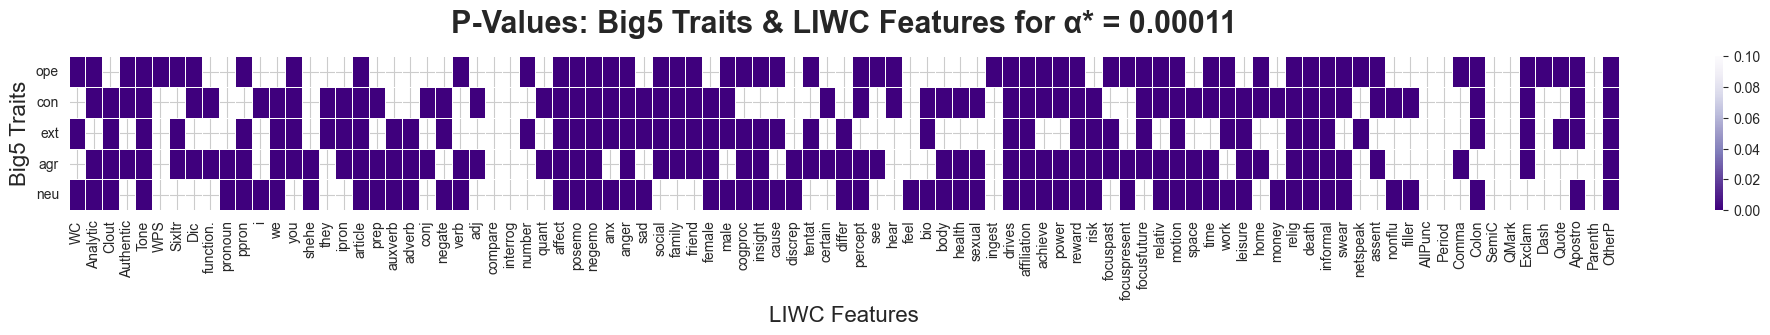

In [53]:
# Compute p-value matrix (Note: features with correlations with itself are removed)
pval_matrix = data.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(len(data.columns))

# Isolating the p-values between Big5 traits and LIWC features
pval_subset = pval_matrix.loc[ocean, liwc].round(3)

# Bonferroni correction for n traits:
#bonferoni_correction = 0.05 / len(ocean)

# Bonferroni correction for n traits * n features (tests):
num_tests = len(ocean) * len(liwc)
bonferoni_correction = 0.05 / num_tests

# define significance level
significance_level = bonferoni_correction

# create mask for p-values
pval_mask = pval_subset > significance_level

# Creating the heatmap
plt.figure(figsize=(25, 2))
sns.heatmap(pval_subset, annot=False, cmap='Purples_r', linewidths=0.5, mask=pval_mask, vmin=0, vmax=0.1)
plt.title(f'P-Values: Big5 Traits & LIWC Features for α* = {round(significance_level, 5)}', fontsize=22, weight='bold', y=1.1)
plt.xlabel('LIWC Features', fontsize=16)
plt.xticks(rotation=90)
plt.ylabel('Big5 Traits', fontsize=16)
plt.yticks(rotation=0);

- Features having a p-value lower than α*:

In [54]:
# store selected features in lists
ope_pval_selected = pval_subset.loc['ope', pval_subset.loc['ope'] < significance_level].index.tolist()
con_pval_selected = pval_subset.loc['con', pval_subset.loc['con'] < significance_level].index.tolist()
ext_pval_selected = pval_subset.loc['ext', pval_subset.loc['ext'] < significance_level].index.tolist()
agr_pval_selected = pval_subset.loc['agr', pval_subset.loc['agr'] < significance_level].index.tolist()
neu_pval_selected = pval_subset.loc['neu', pval_subset.loc['neu'] < significance_level].index.tolist()

# display selected features
for trait in ocean:
    print(f"Trait: {trait}")
    print(17*'~')
    print(pval_subset.loc[trait, pval_subset.loc[trait] <= significance_level].sort_values(ascending=False))
    print(30*'_')

Trait: ope
~~~~~~~~~~~~~~~~~
WC              0.0
home            0.0
affiliation     0.0
achieve         0.0
power           0.0
reward          0.0
focuspast       0.0
focuspresent    0.0
focusfuture     0.0
relativ         0.0
motion          0.0
time            0.0
work            0.0
relig           0.0
ingest          0.0
death           0.0
informal        0.0
swear           0.0
netspeak        0.0
assent          0.0
Comma           0.0
Colon           0.0
Exclam          0.0
Dash            0.0
Quote           0.0
Apostro         0.0
drives          0.0
hear            0.0
Analytic        0.0
posemo          0.0
Authentic       0.0
Tone            0.0
WPS             0.0
Sixltr          0.0
Dic             0.0
ppron           0.0
you             0.0
article         0.0
verb            0.0
number          0.0
affect          0.0
negemo          0.0
see             0.0
anx             0.0
anger           0.0
social          0.0
family          0.0
friend          0.0
male       

- **`Features having a correaltion coefficient > 0.05 & p-value < α*:`**


In [55]:
# apply intersection to select features that are selected by both methods (correlation and p-value)
ope_selected = list(set(ope_corr_selected) & set(ope_pval_selected))
con_selected = list(set(con_corr_selected) & set(con_pval_selected))
ext_selected = list(set(ext_corr_selected) & set(ext_pval_selected))
agr_selected = list(set(agr_corr_selected) & set(agr_pval_selected))
neu_selected = list(set(neu_corr_selected) & set(neu_pval_selected))


print(f"Openness: {ope_selected};  ( {len(ope_selected)} items )")
print(f"Conscientiousness: {con_selected};  ( {len(con_selected)} items )")
print(f"Extroversion: {ext_selected};  ( {len(ext_selected)} items )")
print(f"Agreeableness: {agr_selected};  ( {len(agr_selected)} items )")
print(f"Neuroticism: {neu_selected};  ( {len(neu_selected)} items )")

Openness: ['relativ', 'posemo', 'family', 'drives', 'Exclam', 'informal', 'article', 'number', 'Comma', 'time', 'Sixltr', 'death', 'negemo', 'reward', 'WC', 'focuspast', 'focusfuture', 'WPS', 'insight', 'Apostro', 'percept', 'affect', 'home', 'motion', 'affiliation', 'netspeak'];  ( 26 items )
Conscientiousness: ['Dic', 'relig', 'relativ', 'Clout', 'quant', 'adj', 'OtherP', 'i', 'posemo', 'family', 'Tone', 'anger', 'drives', 'body', 'informal', 'article', 'prep', 'time', 'sad', 'work', 'sexual', 'Colon', 'we', 'death', 'negemo', 'reward', 'swear', 'power', 'social', 'focusfuture', 'certain', 'achieve', 'Apostro', 'home', 'hear', 'motion', 'affiliation'];  ( 37 items )
Extroversion: ['Clout', 'posemo', 'family', 'Tone', 'friend', 'anger', 'drives', 'Exclam', 'risk', 'informal', 'you', 'work', 'Sixltr', 'we', 'death', 'negemo', 'reward', 'social', 'cogproc', 'WC', 'focusfuture', 'insight', 'Apostro', 'affect', 'affiliation', 'netspeak', 'tentat'];  ( 27 items )
Agreeableness: ['Dic', 'pp

In [ ]:
# n elements for all blocks: 24 33 14 24 11

In [ ]:
len(ope_corr_selected), len(ope_pval_selected), len(ope_selected)
#len(con_corr_selected), len(con_pval_selected), len(con_selected)
#len(ext_corr_selected), len(ext_pval_selected), len(ext_selected)
#len(agr_corr_selected), len(agr_pval_selected), len(agr_selected)
#len(neu_corr_selected), len(neu_pval_selected), len(neu_selected)

### **1.3) `[EXTRA EDA]`: Spider Web of Traits vs Consumption**

In [14]:
ocean = ['ope', 'con', 'ext', 'agr', 'neu']
consumption = ['smoking_status', 'alcohol_status', 'drug_status']
ocean_consumption = ocean + consumption


traits_consumption_df = pd.merge(df1, df2, on='userid', how='inner')
traits_consumption_df = traits_consumption_df[ocean_consumption]

# Create groubed dataframes for each consumption habit
smoking_df = traits_consumption_df.groupby('smoking_status').mean()\
                                                            .reset_index()\
                                                            .drop(columns=['alcohol_status', 'drug_status'])\
                                                            .query('smoking_status == True')

alcohol_df = traits_consumption_df.groupby('alcohol_status').mean()\
                                                            .reset_index()\
                                                            .drop(columns=['smoking_status', 'drug_status'])\
                                                            .query('alcohol_status == True')

drug_df = traits_consumption_df.groupby('drug_status').mean()\
                                                      .reset_index()\
                                                      .drop(columns=['smoking_status', 'alcohol_status'])\
                                                      .query('drug_status == True')


traits_consumption_grouped_df = pd.concat([smoking_df, alcohol_df, drug_df], axis=0)
# new column for consumption habit (smoking, alcohol, drug)
traits_consumption_grouped_df['consumption_habit'] = ['smoking', 'alcohol', 'drug']
# drop consumption status columns
traits_consumption_grouped_df.drop(columns=['smoking_status', 'alcohol_status', 'drug_status'], inplace=True)
# set index to consumption habit
traits_consumption_grouped_df.set_index('consumption_habit', inplace=True)
traits_consumption_grouped_df

,ope,con,ext,agr,neu
consumption_habit,,,,,
smoking,4.094466,3.353244,3.328511,3.418206,2.880954
alcohol,4.107285,3.387617,3.304727,3.511543,2.764297
drug,4.171106,3.262010,3.307136,3.450754,2.890754


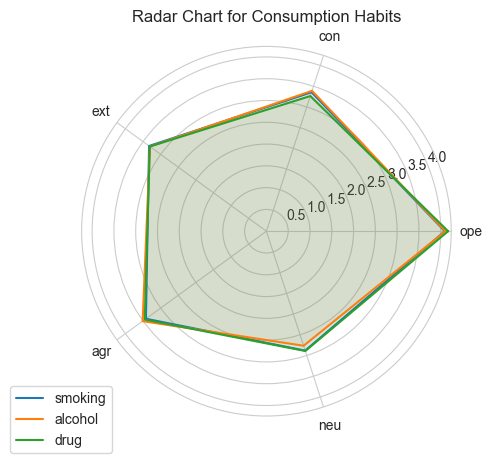

In [20]:


# Function to create a radar chart for multiple groups
def create_multi_radar_chart(df, title):
    categories = list(df.columns)
    N = len(categories)

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories)

    # Plot each consumption habit
    for index, row in df.iterrows():
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, label=index)
        ax.fill(angles, values, alpha=0.1)

    plt.title(title)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# Plotting the radar chart for the consumption habits
create_multi_radar_chart(traits_consumption_grouped_df, "Radar Chart for Consumption Habits")

## ***2) `Cascade Layer 1:` Big5 Modeling***
---

In [24]:
from xgboost import XGBRegressor

import optuna
from optuna.integration import XGBoostPruningCallback

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from tqdm import tqdm

### Store Predictions for Cascade Layer 2:

In [56]:
trait_pred_df = pd.DataFrame()

### ***2.1) Openness:***

 - Optimization:

In [57]:
def objective(trial):
    # Hyperparameter suggestions
    n_estimators  = trial.suggest_int("n_estimators", 39, 900)
    max_depth     = trial.suggest_int("max_depth", 2, 9)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)
    #reg_alpha     = trial.suggest_loguniform('reg_alpha', 1e-4, 1.0)

    # XGBoost model for regression
    model = XGBRegressor(
                    n_estimators  = n_estimators,
                    max_depth     = max_depth,
                    learning_rate = learning_rate,
                    objective     = 'reg:squarederror'
    )

    # Cross-validation with mean squared error (MSE)
    # ---> Note: model is fitted here:
    mse_scores = -cross_val_score(model, X_train1[ope_selected], y_train1['ope'], n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

    # Calculate RMSE (root mean squared error) from MSE
    rmse_scores = np.sqrt(mse_scores)

    # Calculate the average RMSE
    score = sum(rmse_scores) / len(rmse_scores)

    return score



"""Create Study:
   ------------------------------------------------------------------------------------
"""
study = optuna.create_study(direction='minimize')  # Use 'minimize' for RMSE

# Determine the number of trials you want to run
n_trials = 9

# Run the optimization
study.optimize(objective, n_trials=n_trials, timeout=4000)

print(99*'_')

# Get the best trial and its parameters
best_trial = study.best_trial
print('Best trial:', best_trial.params)

[I 2023-12-01 21:42:48,556] A new study created in memory with name: no-name-db4b4e6d-ac13-47b2-9e17-538b0663c0b5
[I 2023-12-01 21:43:20,990] Trial 0 finished with value: 0.5062298758191285 and parameters: {'n_estimators': 510, 'max_depth': 9, 'learning_rate': 0.06572535730423697}. Best is trial 0 with value: 0.5062298758191285.
[I 2023-12-01 21:43:28,853] Trial 1 finished with value: 0.5000140382883462 and parameters: {'n_estimators': 256, 'max_depth': 7, 'learning_rate': 0.003563490827766542}. Best is trial 1 with value: 0.5000140382883462.
[I 2023-12-01 21:43:39,236] Trial 2 finished with value: 0.5087943787123816 and parameters: {'n_estimators': 434, 'max_depth': 7, 'learning_rate': 0.0007561060068989016}. Best is trial 1 with value: 0.5000140382883462.
[I 2023-12-01 21:44:34,719] Trial 3 finished with value: 0.5144348611984906 and parameters: {'n_estimators': 637, 'max_depth': 9, 'learning_rate': 0.00018349428234455862}. Best is trial 1 with value: 0.5000140382883462.
[I 2023-12-0

___________________________________________________________________________________________________
Best trial: {'n_estimators': 402, 'max_depth': 5, 'learning_rate': 0.015447096287366143}


- Model with best Parameters:

In [58]:
# Get the best hyperparameters from the best trial
best_params = study.best_trial.params

# Train an XGBoost model using the best hyperparameters on the training data
best_model = XGBRegressor(
                    n_estimators  = best_params["n_estimators"],
                    max_depth     = best_params["max_depth"],
                    learning_rate = best_params["learning_rate"],
                    objective     = 'reg:squarederror'
)

best_model.fit(
        X_train1[ope_selected],
        y_train1['ope']
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015447096287366143,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=402, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

- Evaluation:

In [59]:
regressor_evaluator(
            model   = best_model,
            X_train = X_train1[ope_selected],
            y_train = y_train1['ope'],
            X_test  = X_test1[ope_selected],
            y_test  = y_test1['ope']
)

,Train,Test
R2 Score,0.225900,0.097009
RMSE,0.456522,0.501216


- Store Predictions:

In [60]:
trait_pred_df['ope_pred'] = best_model.predict(df2[ope_selected])
display_data_shape(trait_pred_df)
trait_pred_df.head()

Data dimensions:
---------------------------------------------------------------------
 - Number of observations: 1,185
 - Number of columns: 1


,ope_pred
0,3.848078
1,4.009212
2,3.997972
3,3.726659
4,3.868549


### ***2.2) Conscientiousness:***

- Optimization:

In [61]:
def objective(trial):
    # Hyperparameter suggestions
    n_estimators  = trial.suggest_int("n_estimators", 39, 900)
    max_depth     = trial.suggest_int("max_depth", 2, 9)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)

    # XGBoost model for regression
    model = XGBRegressor(
                    n_estimators  = n_estimators,
                    max_depth     = max_depth,
                    learning_rate = learning_rate,
                    objective     = 'reg:squarederror'
    )

    # Cross-validation with mean squared error (MSE)
    # ---> Note: model is fitted here:
    mse_scores = -cross_val_score(model, X_train1[con_selected], y_train1['con'], n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

    # Calculate RMSE (root mean squared error) from MSE
    rmse_scores = np.sqrt(mse_scores)

    # Calculate the average RMSE
    score = sum(rmse_scores) / len(rmse_scores)

    return score


"""Create Study:
   ------------------------------------------------------------------------------------
"""
study = optuna.create_study(direction='minimize')  # Use 'minimize' for RMSE

# Determine the number of trials you want to run
n_trials = 9

# Run the optimization
study.optimize(objective, n_trials=n_trials, timeout=4000)

print(99*'_')

# Get the best trial and its parameters
best_trial = study.best_trial
print('Best trial:', best_trial.params)

[I 2023-12-01 21:46:58,579] A new study created in memory with name: no-name-9d6747bf-8d46-45d0-8cf7-c016e017a93c
[I 2023-12-01 21:47:03,198] Trial 0 finished with value: 0.8529126361572736 and parameters: {'n_estimators': 280, 'max_depth': 6, 'learning_rate': 0.9076161997441201}. Best is trial 0 with value: 0.8529126361572736.
[I 2023-12-01 21:47:06,753] Trial 1 finished with value: 0.6506908387220206 and parameters: {'n_estimators': 482, 'max_depth': 4, 'learning_rate': 0.003924128547895517}. Best is trial 1 with value: 0.6506908387220206.
[I 2023-12-01 21:47:09,779] Trial 2 finished with value: 0.6546086190330447 and parameters: {'n_estimators': 53, 'max_depth': 8, 'learning_rate': 0.0872176203336803}. Best is trial 1 with value: 0.6506908387220206.
[I 2023-12-01 21:47:12,013] Trial 3 finished with value: 0.6472107421422241 and parameters: {'n_estimators': 302, 'max_depth': 4, 'learning_rate': 0.01274274197854647}. Best is trial 3 with value: 0.6472107421422241.
[I 2023-12-01 21:47:

___________________________________________________________________________________________________
Best trial: {'n_estimators': 302, 'max_depth': 4, 'learning_rate': 0.01274274197854647}


- Model with best Parameters:

In [62]:
# Get the best hyperparameters from the best trial
best_params = study.best_trial.params

# Train an XGBoost model using the best hyperparameters on the training data
best_model = XGBRegressor(
                    n_estimators  = best_params["n_estimators"],
                    max_depth     = best_params["max_depth"],
                    learning_rate = best_params["learning_rate"],
                    objective     = 'reg:squarederror'
)

best_model.fit(
        X_train1[con_selected],
        y_train1['con']
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01274274197854647,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=302, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

- Evaluate:

In [63]:
regressor_evaluator(
            model   = best_model,
            X_train = X_train1[con_selected],
            y_train = y_train1['con'],
            X_test  = X_test1[con_selected],
            y_test  = y_test1['con']
)

,Train,Test
R2 Score,0.137234,0.097467
RMSE,0.629880,0.648878


- Store Predicitions:

In [64]:
trait_pred_df['con_pred'] = best_model.predict(df2[con_selected])
display_data_shape(trait_pred_df)
trait_pred_df.head()

Data dimensions:
---------------------------------------------------------------------
 - Number of observations: 1,185
 - Number of columns: 2


,ope_pred,con_pred
0,3.848078,3.209746
1,4.009212,3.226825
2,3.997972,3.693022
3,3.726659,3.370677
4,3.868549,3.505023


### ***2.3) Extroversion:***

- Optimization:

In [65]:
def objective(trial):
    # Hyperparameter suggestions
    n_estimators  = trial.suggest_int("n_estimators", 39, 900)
    max_depth     = trial.suggest_int("max_depth", 2, 9)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)

    # XGBoost model for regression
    model = XGBRegressor(
                    n_estimators  = n_estimators,
                    max_depth     = max_depth,
                    learning_rate = learning_rate,
                    objective     = 'reg:squarederror'
    )

    # Cross-validation with mean squared error (MSE)
    # ---> Note: model is fitted here:
    mse_scores = -cross_val_score(model, X_train1[ext_selected], y_train1['ext'], n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

    # Calculate RMSE (root mean squared error) from MSE
    rmse_scores = np.sqrt(mse_scores)

    # Calculate the average RMSE
    score = sum(rmse_scores) / len(rmse_scores)

    return score



"""Create Study:
   ------------------------------------------------------------------------------------
"""
study = optuna.create_study(direction='minimize')  # Use 'minimize' for RMSE

# Determine the number of trials you want to run
n_trials = 9

# Run the optimization
study.optimize(objective, n_trials=n_trials, timeout=4000)

print(99*'_')

# Get the best trial and its parameters
best_trial = study.best_trial
print('Best trial:', best_trial.params)

[I 2023-12-01 21:49:16,370] A new study created in memory with name: no-name-3e037d2f-b872-4b81-954e-9aee99dc157f


[I 2023-12-01 21:49:21,939] Trial 0 finished with value: 0.7672937537042055 and parameters: {'n_estimators': 831, 'max_depth': 5, 'learning_rate': 0.05036026951906973}. Best is trial 0 with value: 0.7672937537042055.
[I 2023-12-01 21:49:37,344] Trial 1 finished with value: 0.7540778772842047 and parameters: {'n_estimators': 657, 'max_depth': 7, 'learning_rate': 0.003968084492488465}. Best is trial 1 with value: 0.7540778772842047.
[I 2023-12-01 21:49:41,385] Trial 2 finished with value: 0.7562857148117847 and parameters: {'n_estimators': 90, 'max_depth': 8, 'learning_rate': 0.020410908435683946}. Best is trial 1 with value: 0.7540778772842047.
[I 2023-12-01 21:49:43,826] Trial 3 finished with value: 0.7708465417492366 and parameters: {'n_estimators': 726, 'max_depth': 3, 'learning_rate': 0.1523960501775748}. Best is trial 1 with value: 0.7540778772842047.
[I 2023-12-01 21:50:41,580] Trial 4 finished with value: 0.7859977120426139 and parameters: {'n_estimators': 727, 'max_depth': 9, 'l

___________________________________________________________________________________________________
Best trial: {'n_estimators': 657, 'max_depth': 7, 'learning_rate': 0.003968084492488465}


- Model with best Parameters:

In [66]:
# Get the best hyperparameters from the best trial
best_params = study.best_trial.params

best_model = XGBRegressor(
                    n_estimators  = best_params["n_estimators"],
                    max_depth     = best_params["max_depth"],
                    learning_rate = best_params["learning_rate"],
                    objective     = 'reg:squarederror'
)

best_model.fit(
        X_train1[ext_selected],
        y_train1['ext']
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.003968084492488465,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=657, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

- Evaluate:

In [67]:
regressor_evaluator(
            model   = best_model,
            X_train = X_train1[ext_selected],
            y_train = y_train1['ext'],
            X_test  = X_test1[ext_selected],
            y_test  = y_test1['ext']
)

,Train,Test
R2 Score,0.274069,0.080604
RMSE,0.673882,0.750965


- Store Predictions:

In [68]:
trait_pred_df['ext_pred'] = best_model.predict(df2[ext_selected])
display_data_shape(trait_pred_df)
trait_pred_df.head()

Data dimensions:
---------------------------------------------------------------------
 - Number of observations: 1,185
 - Number of columns: 3


,ope_pred,con_pred,ext_pred
0,3.848078,3.209746,3.537295
1,4.009212,3.226825,3.605700
2,3.997972,3.693022,3.730462
3,3.726659,3.370677,3.232545
4,3.868549,3.505023,3.576243


### ***2.4) Agreeableness:***

- Optimization:

In [69]:
def objective(trial):
    # Hyperparameter suggestions
    n_estimators  = trial.suggest_int("n_estimators", 99, 900)
    max_depth     = trial.suggest_int("max_depth", 2, 9)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)

    # XGBoost model for regression
    model = XGBRegressor(
                    n_estimators  = n_estimators,
                    max_depth     = max_depth,
                    learning_rate = learning_rate,
                    objective     = 'reg:squarederror'
    )

    # Cross-validation with mean squared error (MSE)
    # ---> Note: model is fitted here:
    mse_scores = -cross_val_score(model, X_train1[agr_selected], y_train1['agr'], n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

    # Calculate RMSE (root mean squared error) from MSE
    rmse_scores = np.sqrt(mse_scores)

    # Calculate the average RMSE
    score = sum(rmse_scores) / len(rmse_scores)

    return score



"""Create Study:
   ------------------------------------------------------------------------------------
"""
study = optuna.create_study(direction='minimize')  # Use 'minimize' for RMSE

# Determine the number of trials you want to run
n_trials = 9

# Run the optimization
study.optimize(objective, n_trials=n_trials, timeout=4000)

print(99*'_')

# Get the best trial and its parameters
best_trial = study.best_trial
print('Best trial:', best_trial.params)

[I 2023-12-01 21:54:35,768] A new study created in memory with name: no-name-1bd75d76-9e57-4cd9-9a90-771354de803c
[I 2023-12-01 21:54:37,690] Trial 0 finished with value: 0.5765926468815215 and parameters: {'n_estimators': 217, 'max_depth': 3, 'learning_rate': 0.002748647355857181}. Best is trial 0 with value: 0.5765926468815215.
[I 2023-12-01 21:54:41,104] Trial 1 finished with value: 0.5639288175310643 and parameters: {'n_estimators': 279, 'max_depth': 5, 'learning_rate': 0.015505995652065056}. Best is trial 1 with value: 0.5639288175310643.
[I 2023-12-01 21:54:50,715] Trial 2 finished with value: 0.5639366935031422 and parameters: {'n_estimators': 818, 'max_depth': 5, 'learning_rate': 0.0039955854424595285}. Best is trial 1 with value: 0.5639288175310643.
[I 2023-12-01 21:54:51,522] Trial 3 finished with value: 0.5641811425484147 and parameters: {'n_estimators': 188, 'max_depth': 2, 'learning_rate': 0.11724607656498828}. Best is trial 1 with value: 0.5639288175310643.
[I 2023-12-01 

___________________________________________________________________________________________________
Best trial: {'n_estimators': 279, 'max_depth': 5, 'learning_rate': 0.015505995652065056}


- Model With best Parameters:

In [70]:
# Get the best hyperparameters from the best trial
best_params = study.best_trial.params

best_model = XGBRegressor(
                    n_estimators  = best_params["n_estimators"],
                    max_depth     = best_params["max_depth"],
                    learning_rate = best_params["learning_rate"],
                    objective     = 'reg:squarederror'
)

best_model.fit(
        X_train1[agr_selected],
        y_train1['agr']
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015505995652065056,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=279, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

- Evaluate:

In [71]:
regressor_evaluator(
            model   = best_model,
            X_train = X_train1[agr_selected],
            y_train = y_train1['agr'],
            X_test  = X_test1[agr_selected],
            y_test  = y_test1['agr']
)

,Train,Test
R2 Score,0.188223,0.092274
RMSE,0.533729,0.565445


- Store Predictions

In [72]:
trait_pred_df['agr_pred'] = best_model.predict(df2[agr_selected])

### ***2.5) Neuroticism:***

- Optimization:

In [73]:
def objective(trial):
    # Hyperparameter suggestions
    n_estimators  = trial.suggest_int("n_estimators", 39, 999)
    max_depth     = trial.suggest_int("max_depth", 2, 9)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)

    # XGBoost model for regression
    model = XGBRegressor(
                    n_estimators  = n_estimators,
                    max_depth     = max_depth,
                    learning_rate = learning_rate,
                    objective     = 'reg:squarederror'
    )

    # Cross-validation with mean squared error (MSE)
    # ---> Note: model is fitted here:
    mse_scores = -cross_val_score(model, X_train1[neu_selected], y_train1['neu'], n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

    # Calculate RMSE (root mean squared error) from MSE
    rmse_scores = np.sqrt(mse_scores)

    # Calculate the average RMSE
    score = sum(rmse_scores) / len(rmse_scores)

    return score



"""Create Study:
   ------------------------------------------------------------------------------------
"""
study = optuna.create_study(direction='minimize')  # Use 'minimize' for RMSE

# Determine the number of trials you want to run
n_trials = 9

# Run the optimization
study.optimize(objective, n_trials=n_trials, timeout=4000)

print(99*'_')

# Get the best trial and its parameters
best_trial = study.best_trial
print('Best trial:', best_trial.params)

[I 2023-12-01 21:57:13,087] A new study created in memory with name: no-name-5ee4b031-eada-4c3b-a881-6a7e5421a9cb
[I 2023-12-01 21:57:21,150] Trial 0 finished with value: 0.8749097897021769 and parameters: {'n_estimators': 333, 'max_depth': 7, 'learning_rate': 0.5275798598112565}. Best is trial 0 with value: 0.8749097897021769.
[I 2023-12-01 21:57:27,084] Trial 1 finished with value: 0.758235070576359 and parameters: {'n_estimators': 427, 'max_depth': 6, 'learning_rate': 0.005636530998686568}. Best is trial 1 with value: 0.758235070576359.
[I 2023-12-01 21:57:41,504] Trial 2 finished with value: 0.7710037545227222 and parameters: {'n_estimators': 244, 'max_depth': 9, 'learning_rate': 0.043386832790014034}. Best is trial 1 with value: 0.758235070576359.
[I 2023-12-01 21:57:49,414] Trial 3 finished with value: 0.7606522071925743 and parameters: {'n_estimators': 615, 'max_depth': 6, 'learning_rate': 0.016628831736289894}. Best is trial 1 with value: 0.758235070576359.
[I 2023-12-01 21:58:

___________________________________________________________________________________________________
Best trial: {'n_estimators': 690, 'max_depth': 4, 'learning_rate': 0.006701563020332028}


- Model With best Parameters:

In [74]:
# Get the best hyperparameters from the best trial
best_params = study.best_trial.params

best_model = XGBRegressor(
                    n_estimators  = best_params["n_estimators"],
                    max_depth     = best_params["max_depth"],
                    learning_rate = best_params["learning_rate"],
                    objective     = 'reg:squarederror'
)

best_model.fit(
        X_train1[neu_selected],
        y_train1['neu']
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.006701563020332028,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=690, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

- Evaluate:

In [75]:
regressor_evaluator(
            model   = best_model,
            X_train = X_train1[neu_selected],
            y_train = y_train1['neu'],
            X_test  = X_test1[neu_selected],
            y_test  = y_test1['neu']
)

,Train,Test
R2 Score,0.126838,0.072649
RMSE,0.733558,0.747932


- Store Predictions

In [76]:
trait_pred_df['neu_pred'] = best_model.predict(df2[neu_selected])
display_data_shape(trait_pred_df)
trait_pred_df.head()

Data dimensions:
---------------------------------------------------------------------
 - Number of observations: 1,185
 - Number of columns: 5


,ope_pred,con_pred,ext_pred,agr_pred,neu_pred
0,3.848078,3.209746,3.537295,3.438730,3.001110
1,4.009212,3.226825,3.605700,3.466096,3.082493
2,3.997972,3.693022,3.730462,3.956110,2.596542
3,3.726659,3.370677,3.232545,3.328371,2.767196
4,3.868549,3.505023,3.576243,3.842054,2.460267


## ***3) `Cascade Layer 2:` Consumption Behavior Modeling***
---

##### Balanced Accuracy:
- Description: Balanced accuracy computes the average of recall obtained on each class. It's useful for dealing with imbalanced datasets.
- Use Case: Good when you have imbalanced classes but care about performance in both classes equally.

In [77]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

- ***Merge consumption behavior to predicted traits:***

In [78]:
trait_pred_df[['smoking_status', 'alcohol_status', 'drug_status']] = df2[['smoking_status', 'alcohol_status', 'drug_status']].astype(int)
display_data_shape(trait_pred_df)
trait_pred_df.head()

Data dimensions:
---------------------------------------------------------------------
 - Number of observations: 1,185
 - Number of columns: 8


,ope_pred,con_pred,ext_pred,agr_pred,neu_pred,smoking_status,alcohol_status,drug_status
0,3.848078,3.209746,3.537295,3.438730,3.001110,1,1,1
1,4.009212,3.226825,3.605700,3.466096,3.082493,0,1,0
2,3.997972,3.693022,3.730462,3.956110,2.596542,0,0,0
3,3.726659,3.370677,3.232545,3.328371,2.767196,0,0,0
4,3.868549,3.505023,3.576243,3.842054,2.460267,1,1,0


- Target variable distribution:

In [84]:
plot_target_ratios(df=trait_pred_df, targets=['smoking_status', 'alcohol_status', 'drug_status'])

- Feature Correlation Analysis:

<Axes: >

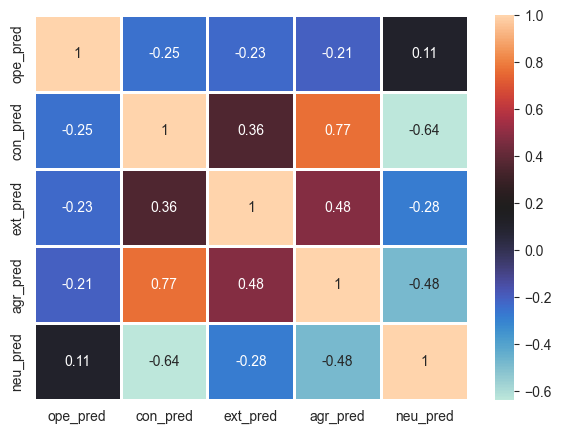

In [79]:
features_corr = trait_pred_df[['ope_pred', 'con_pred', 'ext_pred', 'agr_pred', 'neu_pred']].corr()
plt.figure(figsize=(7, 5))
sns.heatmap(features_corr, annot=True, cmap='icefire', linewidths=1)

- Train-Test-Split:

In [80]:
# train test split:
X2 = trait_pred_df[[c for c in trait_pred_df.columns if c.endswith('_pred')]]

y_smoking, y_alcohol, y_drug = trait_pred_df['smoking_status'], trait_pred_df['alcohol_status'], trait_pred_df['drug_status']


# split data for each of the three targets into train and test sets:

'Smoking'
X_train_smoke, X_test_smoke, \
    y_train_smoke, y_test_smoke = train_test_split(
                                            X2, y_smoking, test_size=0.2, stratify=y_smoking, random_state=42
    )

'Alchohol'
X_train_alc, X_test_alc, \
    y_train_alc, y_test_alc = train_test_split(
                                            X2, y_alcohol, test_size=0.2, stratify=y_alcohol, random_state=42
    )

'Drugs'
X_train_drug, X_test_drug, \
    y_train_drug, y_test_drug = train_test_split(
                                            X2, y_drug, test_size=0.2, stratify=y_drug, random_state=42
    )

- Weights:

In [81]:
# select label frequencies
class_0_smoke, class_1_smoke = y_train_smoke.value_counts()[0], y_train_smoke.value_counts()[1]
class_0_alc, class_1_alc     = y_train_alc.value_counts()[0], y_train_alc.value_counts()[1]
class_0_drug, class_1_drug   = y_train_drug.value_counts()[0], y_train_drug.value_counts()[1]

# compute class weights for each target:
# -> formula = n negative samples / n positive samples
weight_smoke = round(class_0_smoke / class_1_smoke, 2)
weight_alc   = round(class_0_alc / class_1_alc, 2)
weight_drugs = round(class_0_drug / class_1_drug, 2)

# display as dataframe
pd.DataFrame(
        data    = [[weight_smoke, weight_alc, weight_drugs]],
        columns = ['smoking_status', 'alcohol_status', 'drug_status'],
        index   = ['weights']
).transpose()

,weights
smoking_status,2.98
alcohol_status,1.07
drug_status,4.42


### ***3.1) Smoking***

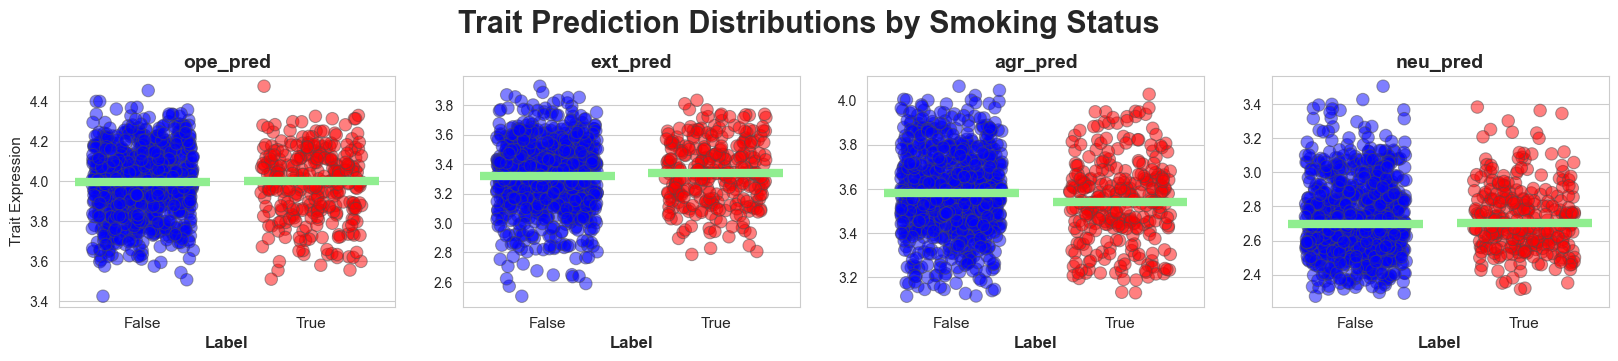

In [82]:
plot_continuous_features_target(
                    df       = trait_pred_df,
                    features = ['ope_pred', 'ext_pred', 'agr_pred', 'neu_pred'],
                    target   = 'smoking_status',
                    title    = 'Trait Prediction Distributions by Smoking Status',
                    figsize   = (20, 3)
)

- Optimization

In [97]:
def objective(trial):
    # Hyperparameter suggestions
    n_estimators  = trial.suggest_int("n_estimators", 39, 296)
    max_depth     = trial.suggest_int("max_depth", 2, 9)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.3)
    reg_alpha     = trial.suggest_loguniform('reg_alpha', 1e-6, 1.0)
    #weight_smoke  = weight_smoke #trial.suggest_int("scale_pos_weight", 2, 6)

    # XGBoost model
    model = XGBClassifier(
                    n_estimators     = n_estimators,
                    max_depth        = max_depth,
                    learning_rate    = learning_rate,
                    reg_alpha        = reg_alpha,
                    scale_pos_weight = weight_smoke,
                    eval_metric      = 'logloss'
    )

    # F1 scorer for cross-validation
    f1_scorer = make_scorer(f1_score, average='binary')

    # Balanced accuracy scorer for cross-validation
    bal_acc_scorer = make_scorer(balanced_accuracy_score)
    
    # initialize StratifiedKFold
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Cross-validation with F1 score
    score = cross_val_score(
                        estimator = model,
                        X         = X_train_smoke,
                        y         = y_train_smoke,
                        n_jobs    = -1,
                        cv        = stratified_cv,
                        scoring   = bal_acc_scorer
    ).mean()

    return score



"""Create Study:
   ------------------------------------------------------------------------------------
"""
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=28, timeout=4000)  # 100 trials or 600 seconds

print(99*'_')
print('Best trial:', study.best_trial.params)

[I 2023-12-01 22:10:16,268] A new study created in memory with name: no-name-77b32dac-c32a-43eb-a096-039fd269b4c1
[I 2023-12-01 22:10:16,481] Trial 0 finished with value: 0.5562385180649112 and parameters: {'n_estimators': 157, 'max_depth': 3, 'learning_rate': 0.0074979946012924265, 'reg_alpha': 0.0035931347852117906}. Best is trial 0 with value: 0.5562385180649112.
[I 2023-12-01 22:10:16,855] Trial 1 finished with value: 0.5504975505205144 and parameters: {'n_estimators': 123, 'max_depth': 7, 'learning_rate': 0.17653637811659892, 'reg_alpha': 0.0002415248582088766}. Best is trial 0 with value: 0.5562385180649112.
[I 2023-12-01 22:10:17,454] Trial 2 finished with value: 0.5415250561339049 and parameters: {'n_estimators': 265, 'max_depth': 5, 'learning_rate': 0.005227235477815591, 'reg_alpha': 0.00021356400678516105}. Best is trial 0 with value: 0.5562385180649112.
[I 2023-12-01 22:10:18,700] Trial 3 finished with value: 0.548090171463564 and parameters: {'n_estimators': 177, 'max_depth

___________________________________________________________________________________________________
Best trial: {'n_estimators': 227, 'max_depth': 2, 'learning_rate': 0.041347826055682914, 'reg_alpha': 7.120989221661035e-06}


- Retrieve best Parameters and Refit:

In [101]:
best_model = XGBClassifier(
                    n_estimators     = study.best_trial.params["n_estimators"],
                    max_depth        = study.best_trial.params["max_depth"],
                    learning_rate    = study.best_trial.params["learning_rate"],
                    reg_alpha        = study.best_trial.params["reg_alpha"],
                    scale_pos_weight = weight_smoke, #study.best_trial.params["scale_pos_weight"],
                    eval_metric      = 'logloss'
)

best_model.fit(
        X_train_smoke,
        y_train_smoke
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.041347826055682914, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=227, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

- Evaluation:

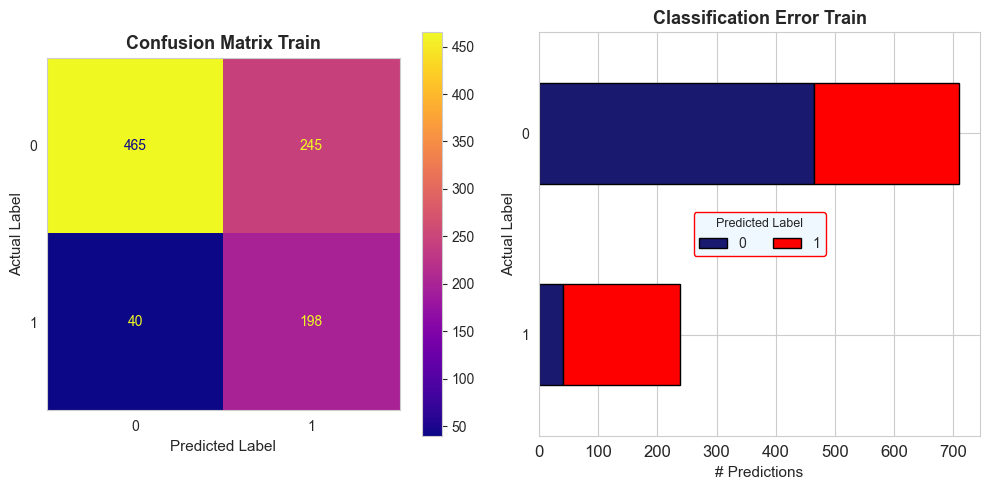

Class Distribution in Dataset:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
- Class 0: 710 (75.0%)
- Class 1: 238 (25.0%)

Classification Report Train:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.920792,0.654930,0.765432,710.000000
1,0.446953,0.831933,0.581498,238.000000
accuracy,0.699367,0.699367,0.699367,0.699367
macro avg,0.683872,0.743431,0.673465,948.000000
weighted avg,0.801832,0.699367,0.719254,948.000000


In [102]:
classification_evaluation_report(
                            model       = best_model,
                            X           = X_train_smoke,
                            y           = y_train_smoke,
                            title_suffix = 'Train',
                            figsize      = (10, 5)
)

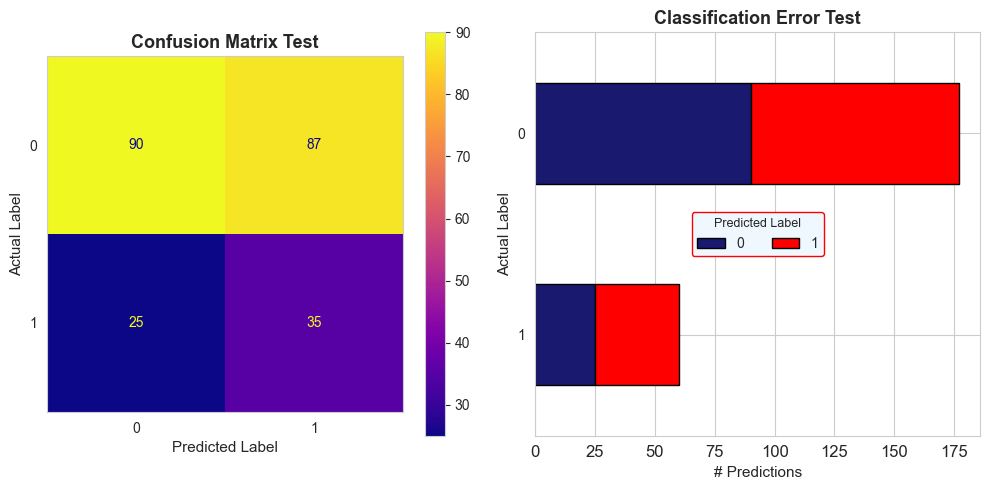

Class Distribution in Dataset:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
- Class 0: 177 (75.0%)
- Class 1: 60 (25.0%)

Classification Report Test:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.782609,0.508475,0.616438,177.000000
1,0.286885,0.583333,0.384615,60.000000
accuracy,0.527426,0.527426,0.527426,0.527426
macro avg,0.534747,0.545904,0.500527,237.000000
weighted avg,0.657109,0.527426,0.557749,237.000000


In [103]:
classification_evaluation_report(
                            model       = best_model,
                            X           = X_test_smoke,
                            y           = y_test_smoke,
                            title_suffix = 'Test',
                            figsize      = (10, 5)
)

- Threshold Analysis:

- Evaluate on adjusted Thresholds:

### ***3.2) Alcohol***

- Optimization

In [144]:
def objective(trial):
    # Hyperparameter suggestions
    n_estimators     = trial.suggest_int("n_estimators", 39, 299)
    max_depth        = trial.suggest_int("max_depth", 2, 9)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 9)
    subsample        = trial.suggest_loguniform('subsample', 0.001, 1.0)
    colsample_bytree = trial.suggest_loguniform('colsample_bytree', 0.001, 1.0)
    learning_rate    = trial.suggest_loguniform('learning_rate', 0.001, 0.3)
    reg_alpha        = trial.suggest_loguniform('reg_alpha', 1e-6, 1.0)

    # XGBoost model
    model = XGBClassifier(
                    n_estimators     = n_estimators,
                    max_depth        = max_depth,
                    min_child_weight = min_child_weight,
                    subsample        = subsample,
                    colsample_bytree = colsample_bytree,
                    learning_rate    = learning_rate,
                    reg_alpha        = reg_alpha,
                    eval_metric      = 'logloss'
    )

    # F1 scorer for cross-validation
    f1_scorer = make_scorer(f1_score, average='binary')

    # Balanced accuracy scorer for cross-validation
    bal_acc_scorer = make_scorer(balanced_accuracy_score)

    # initialize StratifiedKFold
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    # Cross-validation with F1 score
    score = cross_val_score(
                        estimator = model,
                        X         = X_train_alc,
                        y         = y_train_alc,
                        n_jobs    = -1,
                        cv        = stratified_cv,
                        scoring   = bal_acc_scorer
    ).mean()

    return score

# Create Study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=99, timeout=4000)

print(99*'_')
print('Best trial:', study.best_trial.params)

[I 2023-12-02 23:45:39,543] A new study created in memory with name: no-name-28646d70-09b1-497b-8b05-a4f0876b139f
[W 2023-12-02 23:45:39,758] Trial 0 failed with parameters: {'n_estimators': 272, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.049676021259873, 'colsample_bytree': 0.001730662667612426, 'learning_rate': 0.018980869631964978, 'reg_alpha': 0.0010287677559780376} because of the following error: TypeError("cross_val_score() got an unexpected keyword argument 'stratify'").
Traceback (most recent call last):
  File "/Users/sebastianwefers/Desktop/SEMESTER5/Domainspecific_Case_Studies_Tools/myenv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/20/y44pt9c51ts69c9fjlbm2glh0000gn/T/ipykernel_23917/803898033.py", line 30, in objective
    score = cross_val_score(
TypeError: cross_val_score() got an unexpected keyword argument 'stratify'
[W 2023-12-02 23:45:39,800] Trial 0 failed with value

TypeError: cross_val_score() got an unexpected keyword argument 'stratify'

- Retrieve best Parameters and Refit:

In [141]:
best_model = XGBClassifier(
                    n_estimators     = study.best_trial.params["n_estimators"],
                    max_depth        = study.best_trial.params["max_depth"],
                    subsample        = study.best_trial.params["subsample"],
                    colsample_bytree = study.best_trial.params["colsample_bytree"],
                    min_child_weight = study.best_trial.params["min_child_weight"],
                    learning_rate    = study.best_trial.params["learning_rate"],
                    reg_alpha        = study.best_trial.params["reg_alpha"],
                    eval_metric      = 'logloss'
)

best_model.fit(
        X_train_alc,
        y_train_alc
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.024375186319066593, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13154411058602783,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=204, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

- Evaluate:

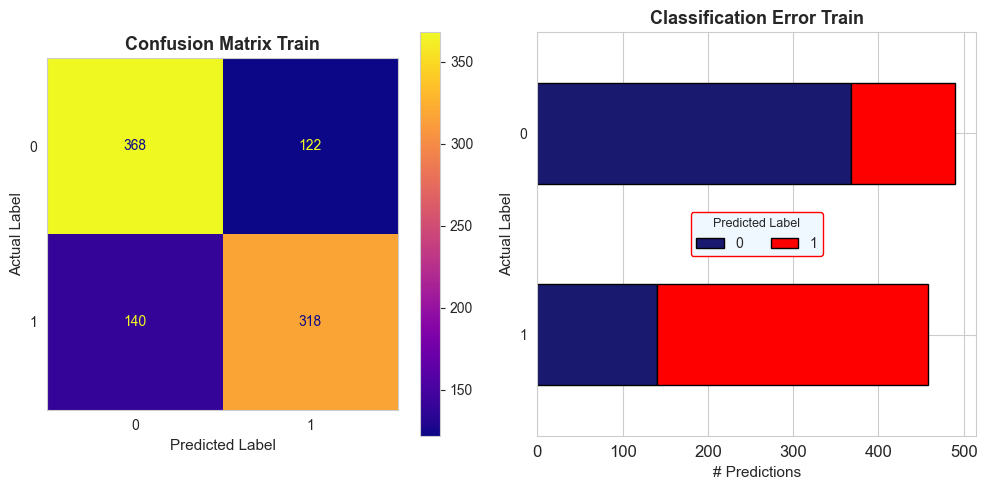

Class Distribution in Dataset:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
- Class 0: 490 (52.0%)
- Class 1: 458 (48.0%)

Classification Report Train:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.724409,0.751020,0.737475,490.000000
1,0.722727,0.694323,0.708241,458.000000
accuracy,0.723629,0.723629,0.723629,0.723629
macro avg,0.723568,0.722672,0.722858,948.000000
weighted avg,0.723597,0.723629,0.723351,948.000000


In [142]:
classification_evaluation_report(
                            model       = best_model,
                            X           = X_train_alc,
                            y           = y_train_alc,
                            title_suffix = 'Train',
                            figsize      = (10, 5)
)

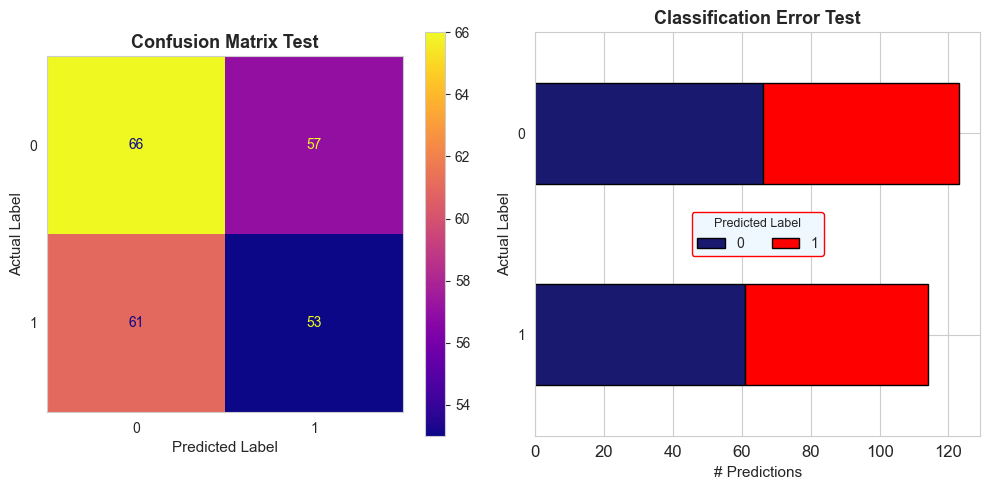

Class Distribution in Dataset:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
- Class 0: 123 (52.0%)
- Class 1: 114 (48.0%)

Classification Report Test:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.519685,0.536585,0.528000,123.000000
1,0.481818,0.464912,0.473214,114.000000
accuracy,0.502110,0.502110,0.502110,0.502110
macro avg,0.500752,0.500749,0.500607,237.000000
weighted avg,0.501471,0.502110,0.501647,237.000000


In [143]:
classification_evaluation_report(
                            model       = best_model,
                            X           = X_test_alc,
                            y           = y_test_alc,
                            title_suffix = 'Test',
                            figsize      = (10, 5)
)

- Threshold Analysis:

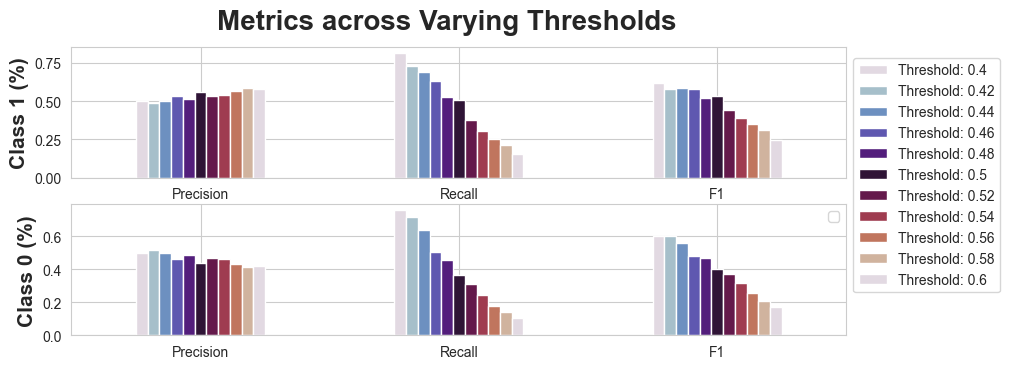

In [139]:
threshold_analysis_barplot(
                    model       = best_model,
                    X           = X_test_alc,
                    y           = y_test_alc,
                    thresholds  = np.arange(0.4, 0.62, 0.02).round(2),
                    figsize      = (10, 3.75)
)

- Evaluate on adjusted Thresholds:

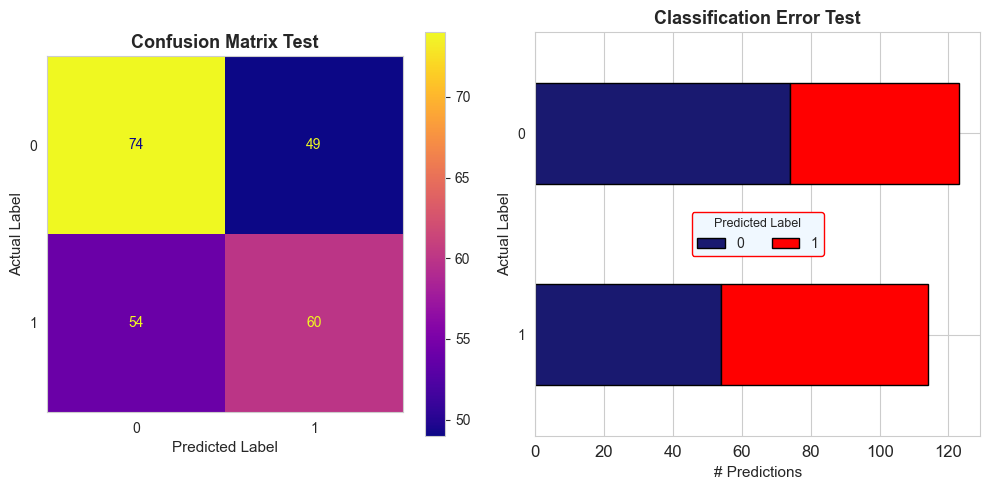

Class Distribution in Dataset:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
- Class 0: 123 (52.0%)
- Class 1: 114 (48.0%)

Classification Report Test:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,precision,recall,f1-score,support
0,0.578125,0.601626,0.589641,123.000000
1,0.550459,0.526316,0.538117,114.000000
accuracy,0.565401,0.565401,0.565401,0.565401
macro avg,0.564292,0.563971,0.563879,237.000000
weighted avg,0.564817,0.565401,0.564857,237.000000


In [129]:
classification_evaluation_report(
                            model       = best_model,
                            X           = X_test_alc,
                            y           = y_test_alc,
                            title_suffix = 'Test',
                            threshold   = 0.5,
                            figsize      = (10, 5)
)

### ***3.3) Drugs***

- Optimization

- Retrieve best Parameters and Refit:

- Threshold Analysis:

- Evaluate on adjusted Thresholds: